# Constellation Learning in an AWGN Channel

In this notebook, we will learn how to implement an end-to-end digital communication system as an `AutoEncoder`[1] and compared its performance with a `(n,k) Hamming Code`. 

 * We analyze the performance of an autoencoder based modeling of a communication system as opposed to                  traditional modeling, where designing signal alphabet at transmitter (Tx) and detection algorithms at    receiver    (Rx) are based on a given mathematical/statistical channel/system model.
 

 * We simulate the performance of an AutoEncoder based communication link in the presence of Additive White Gaussian    Noise (AWGN), where Tx sends one out of ``M`` message/information symbols per `n` channel uses through a noisy      channel and the Rx estimates the transmitted symbols through noisy observations.
 

* `The goal is to learn a signalling alphabet/constellation scheme that is robust with respect to the noise            introduced by the channel at Tx`



 ## Table of Contents

* [Importing Libraries](#import-libraries)
* [Parameters of AE](#AE-parameters)
* [Training Data](#training-data-set)
* [Testing Data](#testing-data-set)
* [Normalization Functions](#norm-func)
* [Defining AE Model](#AE-model)
* [Training AE](#AE-training)
* [Defining Tx, Channel and Rx from Trained AE](#individual-model)
* [Constellation Learning](#constellation-learning)
* [Block Error Rate (BLER) performance](#BLER)
* [References](#ref)









### PHY layer as AutoEncoder

* The fundamental idea behind this tutorial is to model Physical Layer as an ``AutoEncoder``(AE).


* An ``AutoEncoder``(AE) is an Artificial Neural Network (ANN) used to learn an efficient representation of data at   an intermediate layer to reproduce the input at its output.


* We Interpret end to end communication link, i.e., Tx, channel, and Rx as a single Neural Network (NN) that can be   trained as an AE which reconstructs its input at its output, as communication is all about                           reproducing/reconstructing messages transmitted by Tx at Rx faithfully in the presence of channel perturbations     and Rx noise.

### Steps

Following are the steps that we follow in simulation:

* Define the hyper parameters of AE :
    - number of information symbols `M`, where each symbol carry `k`bits
    
    - number of channel uses `n`
    
    - snr in dB at which AE is being trained, which we call `snr_train`
    
    
    
* Define embedings for each information symbol that is to be fed as an input to AE.


* Define training and testing data set by randomizing the label


* Define end to end AutoEncoder by using the already imported `keras` built in layers.

    - Tx is being implmented as a stack of two keras `Dense` layers one with `ReLU` activation and another with           `linear` activation. The output of the second Dense layer is fed to a normalization layer which we implement         using keras `Lambda` layer.
    
    - Channel is implemented as a single `Noise` layer with certain noise standard deviation, which is a function of       both Rate of the code (R) and snr_train.
    
    - Rx also consists of two keras Dense layers, one with `ReLU` activation and the last one with `softmax`               activation. The last layer must output probabilities (i.e., for a given received noisy vector **v** of               dimension M, it outputs max aposteriori probability vector of dimension M, i.e.,                                     max(prob(**w**|**v**)) for any **w** belongs to transmitted oneshot embeddings)

**Note:**  We choose different values of number of training (`N`) and testing samples (`N_test`) for constellation plots and for BlockErrorRate (BLER) plots.


**Note:** For `(n,k) = (7,4)`, we use `sklearn T-distributed Stochastic Neighbor Embedding (TSNE)` to plot the learned constellation. Typically we use less number of `N` and `N_test` in such cases.
For BLER plots we always go with high values of `N`, `N_test`   

![title](img/autoencoder.png)

## Importing Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


# Importing necessary Numpy, Matplotlib, TensorFlow, Keras and scikit-learn modules
%matplotlib widget
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, GaussianNoise, Lambda, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras import backend as be

The following code cell defines the parametes of an AutoEncoder including the `snr_dB` at which it is being trained.
We assume (n,k) = (7,4) here but the code is generailized to support other configurations as well such as (2,4) and (2,2) given in [1] 

## Parameters of AutoEncoder

In [2]:
#################################################
# Parameters of a (n,k) AutoEncoder (AE)
# all the symbols are assumed to be real valued
#################################################

# number of information/message symbols that Tx communicates over channel to Rx
M = 16 
# number of bits per information symbol
k = int(np.log2(M)) 
# number of channel uses or dimension of each code-word symbol or number of bits per code-word symbol
n = 7
# Rate of communication. i.e., k bits per n channel uses
R = k/n 
print("###################################################################################################")
print("Parameters of "+str((n,k))+" AutoEncoder are:\n")
print("Number of Information Symbols:" + str(M))
print("Number of Bits Per Information Symbol:" + str(k))
print("Number of Channel Uses:" + str(n))
print("Rate of Communication:" + str(R))

###################################################################################################
Parameters of (7, 4) AutoEncoder are:

Number of Information Symbols:16
Number of Bits Per Information Symbol:4
Number of Channel Uses:7
Rate of Communication:0.5714285714285714


In [3]:
###################################
#SNR at which AE is being trained
###################################
#---------------------------------------------------------------------------------------------------------------
# SNR in dB = Es/No, where Es: Energy per symbol, No: Noise Power Spectral Density
snr_dB = 7 
# snr in linear scale
snr_train = np.power(10,snr_dB/10) 
# noise standard deviation
noise_stddev = np.sqrt(1/(2*R*snr_train))

## Training Data

In [4]:
#############################################
# One-hot embeddings of information symbols.
#############################################
# Each information symbol is mapped to a standard basis vector of dimension M

symbol_encodings = np.eye(M) 
print("One-Hot Encodings of information symbols:\n")
print(symbol_encodings)

One-Hot Encodings of information symbols:

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [5]:
###############################################################################
# Generating data samples of size N. Each sample can take values from 0 to M-1
###############################################################################
N  = 9600000
#*********************************************************************************
# use this value of N only for Constellation plot when using TSNE under (7,4) AE
# N = 1500
#*********************************************************************************
# random indices for labeling information symbols
train_label = np.random.randint(M,size=N)
print(train_label)

[ 0  1  9 ...  8 13  8]


In [6]:
########################
# Training data samples
########################
data = []
for i in train_label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)
# converting data in to a numpy array    
train_data = np.array(data)
print("\n")
# Printing the shape of training data
print("The shape of training data:")
print(train_data.shape)



The shape of training data:
(9600000, 16)


In [7]:
# Verifying training data with its label or index for 13 samples

tempLabel_train = np.random.randint(N,size=13)
print(tempLabel_train)
print("\n")
for i in tempLabel_train:
    print(train_label[i],train_data[i])

[ 470109 1931495 8462352 5178934 3248794 7178125 6558540 6423621 5118237
 3170137 7780153 4432076  839543]


13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Testing Data

In [8]:
###############################
# Generating data for testing
###############################
N_test = 16000
#**************************************************
# use this only for Constellation Plot of (7,4) AE
# N_test = 500
#**************************************************
test_label = np.random.randint(M,size=N_test)
test_data = []
for i in test_label:
    temp    = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
# converting it to a numpy array     
test_data = np.array(test_data)
# Printing the shape of test data
print("The shape of test data is:")
print(test_data.shape)

The shape of test data is:
(16000, 16)


In [9]:
# Verifying test data with its label for 7 sample
tempTestLabel = np.random.randint(N_test,size=7)
print(tempTestLabel)
print("\n")
for i in tempTestLabel:
    print(test_label[i],test_data[i])


[ 7316 10761  6606 15068 13182 10857 13890]


8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
14 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
11 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Normalization Functions

In [10]:
def normalizeAvgPower(x):
    """ Normalizes the power of input tensor"""
    return x/(be.sqrt(be.mean(x**2)))

In [11]:
def normalizeEnergy(x):
    """ Normalizes the energy of input tensor"""
    return np.sqrt(n)*(be.l2_normalize(x,axis=-1))

## Defining AutoEncoder Model

In [12]:
##########################################
# Defining AutoEncoder and its layers
##########################################
#----------------------------------------------------------------------------------------------------------------
###########
# Tx layer
###########
onehot  = Input(shape=(M,))
dense1  = Dense(M, activation = 'relu')(onehot)
dense2  = Dense(n, activation = 'linear')(dense1)
x       = Lambda(normalizeAvgPower)(dense2)      # Avg power constraint
# x       = Lambda(normalizeEnergy)(dense2)      # Energy constraint
#****************************************************************************************
################
# Channel Layer
################
y       = GaussianNoise(stddev = noise_stddev)(x)
#****************************************************************************************
###########
# Rx layer
###########
dense3  = Dense(M, activation = 'relu')(y)
prob    = Dense(M, activation = 'softmax')(dense3) 
#-----------------------------------------------------------------------------------------------------------------
#########################################
# Defining end to end AutoEncoder Model
#########################################
autoEncoder = Model(onehot, prob)
#-----------------------------------------------------------------------------------------------------------------
# Instantiate optimizer
adam        = Adam(learning_rate=0.01)
# Instantiate Stochastic Gradient Descent Method
sgd         = SGD(learning_rate=0.02)
#-----------------------------------------------------------------------------------------------------------------
# compile end to end model
autoEncoder.compile(optimizer=adam, loss='categorical_crossentropy')
#-----------------------------------------------------------------------------------------------------------------
# printing summary of layers and its trainable parameters
print(autoEncoder.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 7)                 119       
                                                                 
 lambda (Lambda)             (None, 7)                 0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 7)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 16)                128       
                                                             

In the following code snippet we show how to train an end to end AE by a call to `fit()` method specifying the training and validation data. We choose 50 `epochs` with a `batch_size` of 1024. One can vary these values to obtain a different trainable model.

## Training AutoEncoder

In [13]:
#######################
# Training Auto Encoder
########################
autoEncoder.fit(train_data, train_data,
                epochs = 50,
                batch_size = 8*1024,
                validation_data=(test_data, test_data))

Epoch 1/50
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0637 - val_loss: 2.3723e-06
Epoch 2/50
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0016 - val_loss: 1.1986e-07
Epoch 3/50
1172/1172 [==============================] - 2s 2ms/step - loss: 0.0011 - val_loss: 7.2122e-09
Epoch 4/50
1172/1172 [==============================] - 2s 2ms/step - loss: 9.5119e-04 - val_loss: 0.0000e+00
Epoch 5/50
1172/1172 [==============================] - 2s 2ms/step - loss: 8.6385e-04 - val_loss: 0.0000e+00
Epoch 6/50
1172/1172 [==============================] - 2s 2ms/step - loss: 7.6675e-04 - val_loss: 0.0000e+00
Epoch 7/50
1172/1172 [==============================] - 2s 2ms/step - loss: 7.2859e-04 - val_loss: 0.0000e+00
Epoch 8/50
1172/1172 [==============================] - 2s 2ms/step - loss: 6.8370e-04 - val_loss: 0.0000e+00
Epoch 9/50
1172/1172 [==============================] - 2s 2ms/step - loss: 6.5677e-04 - val_loss: 0.0000e+00
Epoch 10/50
1172/1172 

## Defining Tx, Channel and Rx from Trained AutoEncoder

In [14]:
########################################################
# Defining Tx from end to end trained autoEncoder model
#######################################################

transmitter   = Model(onehot, x)
#*********************************************************
#######################
# Defining channel part 
#######################
channelInput  = Input(shape=(n,))
channelOutput = autoEncoder.layers[-3](channelInput)
channel       = Model(channelInput, channelOutput)
#*********************************************************
##################
# Defining Rx part
##################
rxInput       = Input(shape=(n,))
rx1           = autoEncoder.layers[-2](rxInput)
rxOutput      = autoEncoder.layers[-1](rx1)
receiver      = Model(rxInput,rxOutput)

## Block Error Rate (BLER) performance

The following code snippet computes and plots BLER performance of of `(n,k) AE` and compares it with base line `(n,k) Hamming code`.


**Note:** Run the following code snippets only with high values of `N`, `N_test`. Comment all the following code snippet for constellation plots. Uncomment only for BLER plots

In [15]:
#######################################
# SNR vs BLER computation and plotting
#######################################
# use this snr_dB = np.arange(0,15,2) for (n,k) = (2,4) or (2,2) AE
# use this snr_dB = np.arange(-4,8.5,0.5) for (7,4) AE 

snr_dB = np.arange(-4,8.5,0.5)
bler   = np.zeros(snr_dB.shape[0])
for ii in range(0,snr_dB.shape[0]):
    snr_linear      = 10.0**(snr_dB[ii]/10.0)      # snr in linear scale
    noise_std       = np.sqrt(1/(2*R*snr_linear))
    noise_mean      = 0
    num_errors      = 0
    num_samples     = N_test 
    #-------------------------------------------------------------
    noise           = noise_std*np.random.randn(num_samples,n)
    #-------------------------------------------------------------
    #########################
    # predicted input symbols
    #########################
    x_hat           = transmitter.predict(test_data)
    #-------------------------------------------------------------
    ##############
    # noisy input
    ##############
    x_hat_noisy     = x_hat + noise
    #-------------------------------------------------------------
    ##########################
    # predicted output symbols
    ##########################
    y_hat           = receiver.predict(x_hat_noisy)
    #-------------------------------------------------------------
    ##################
    # symbol estimates
    ##################
    sym_estimates   = np.argmax(y_hat, axis=1) 
    #-------------------------------------------------------------
    #################################################
    # counting errors and computing bler at each snr
    #################################################
    num_errors      = int(np.sum(sym_estimates != test_label))    
    bler[ii]        = num_errors/num_samples
    print('SNR(dB):', snr_dB[ii], 'BLER:', bler[ii])
    

500/500 [==============================] - 0s 377us/step
SNR(dB): -4.0 BLER: 0.4993125
500/500 [==============================] - 0s 348us/step
SNR(dB): -3.5 BLER: 0.4599375
500/500 [==============================] - 0s 340us/step
SNR(dB): -3.0 BLER: 0.422875
500/500 [==============================] - 0s 336us/step
SNR(dB): -2.5 BLER: 0.3785625
500/500 [==============================] - 0s 370us/step
SNR(dB): -2.0 BLER: 0.345
500/500 [==============================] - 0s 345us/step
SNR(dB): -1.5 BLER: 0.2955
500/500 [==============================] - 0s 344us/step
SNR(dB): -1.0 BLER: 0.25825
500/500 [==============================] - 0s 357us/step
SNR(dB): -0.5 BLER: 0.2233125
500/500 [==============================] - 0s 349us/step
SNR(dB): 0.0 BLER: 0.1851875
500/500 [==============================] - 0s 354us/step
SNR(dB): 0.5 BLER: 0.152625
500/500 [==============================] - 0s 355us/step
SNR(dB): 1.0 BLER: 0.1163125
500/500 [==============================] - 0s 353us/step


## Hamming Codes

### Importing necessary libraries

In [16]:
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper
from toolkit5G.ChannelCoder  import HammingEncoder
from toolkit5G.ChannelCoder  import HammingDecoder

### Transmitter

In [17]:
##############################
## Hamming Code Configurations
##############################
## (n,k) code for any random positive integer m
m = 3            
k = 2**m - m - 1
n = 2**m - 1
#------------------------------------------------
## Payload Generation
numDim = 2
n1     = 1000000
bits   = np.random.randint(2, size = (n1,k))

#-------------------------------------------------
## Hamming Encoder
encBits = HammingEncoder(k,n)(bits)

## Rate Matching
codeword = encBits

## Symbol Mapping
constellation_type  = "bpsk"
num_bits_per_symbol = 1

mapperObject        = Mapper(constellation_type, num_bits_per_symbol)
symbols             = mapperObject(codeword)

print()
print("******** ("+str(n)+","+str(k)+") Hamming Code ********")
print("       Shape of Input:"+str(bits.shape))
print("    Shape of Enc Bits:"+str(encBits.shape))
print("   Constellation type: "+str(constellation_type))
print("Number of bits/symbol: "+str(num_bits_per_symbol))
print("*********************************")
print()


******** (7,4) Hamming Code ********
       Shape of Input:(1000000, 4)
    Shape of Enc Bits:(1000000, 7)
   Constellation type: bpsk
Number of bits/symbol: 1
*********************************



In [18]:
######################################
# (7,4) Hamming code BLER performance
######################################

SNR  = 10**(snr_dB/10)  # SNR in linear scale

codedBLERhard = np.zeros(SNR.shape)
codedBLERsoft = np.zeros(SNR.shape)

## Symbol Demapping
# demapping_method = str(np.random.choice(["app", "maxlog"]))
# hard_out         = bool(np.random.choice([False, True]))
demapping_method = "app"
hard_out         = False

demapper         = Demapper(demapping_method, constellation_type, 
                            num_bits_per_symbol, hard_out = hard_out)


snrIndex = 0
for snr in SNR:
    symbs = symbols + np.sqrt(0.5/R/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

    llrEst  = demapper([symbs, np.float32(1/snr)])
    uncBits = np.where(llrEst > 0, np.int8(1), np.int8(0))
        
    decoder = HammingDecoder(k,n)
    decBits = decoder(uncBits)
    
    codedBLERhard[snrIndex]= np.mean(np.where(np.sum(np.abs(bits-decBits), axis=1)>0, True, False))
    
    decoder = HammingDecoder(k,n)
    decBits = decoder(llrEst, "sphereDecoding")
    
    codedBLERsoft[snrIndex]= np.mean(np.where(np.sum(np.abs(bits-decBits), axis=1)>0, True, False))
    
    print("At SNR(dB): "+str(snr_dB[snrIndex])+" | coded BLER (soft): "+str(codedBLERsoft[snrIndex])+" | coded BLER(hard): "+str(codedBLERhard[snrIndex]))

    snrIndex += 1
    

At SNR(dB): -4.0 | coded BLER (soft): 0.487356 | coded BLER(hard): 0.555567
At SNR(dB): -3.5 | coded BLER (soft): 0.451116 | coded BLER(hard): 0.523247
At SNR(dB): -3.0 | coded BLER (soft): 0.413188 | coded BLER(hard): 0.488804
At SNR(dB): -2.5 | coded BLER (soft): 0.374117 | coded BLER(hard): 0.454112
At SNR(dB): -2.0 | coded BLER (soft): 0.334626 | coded BLER(hard): 0.41793
At SNR(dB): -1.5 | coded BLER (soft): 0.294037 | coded BLER(hard): 0.378983
At SNR(dB): -1.0 | coded BLER (soft): 0.254819 | coded BLER(hard): 0.340943
At SNR(dB): -0.5 | coded BLER (soft): 0.215494 | coded BLER(hard): 0.300886
At SNR(dB): 0.0 | coded BLER (soft): 0.178729 | coded BLER(hard): 0.262009
At SNR(dB): 0.5 | coded BLER (soft): 0.144913 | coded BLER(hard): 0.224729
At SNR(dB): 1.0 | coded BLER (soft): 0.114015 | coded BLER(hard): 0.188273
At SNR(dB): 1.5 | coded BLER (soft): 0.086872 | coded BLER(hard): 0.154788
At SNR(dB): 2.0 | coded BLER (soft): 0.063531 | coded BLER(hard): 0.123273
At SNR(dB): 2.5 | 

### BLER plot : comparison of AutoEncoder BLER with base line (n,k) Hamming Code BLER

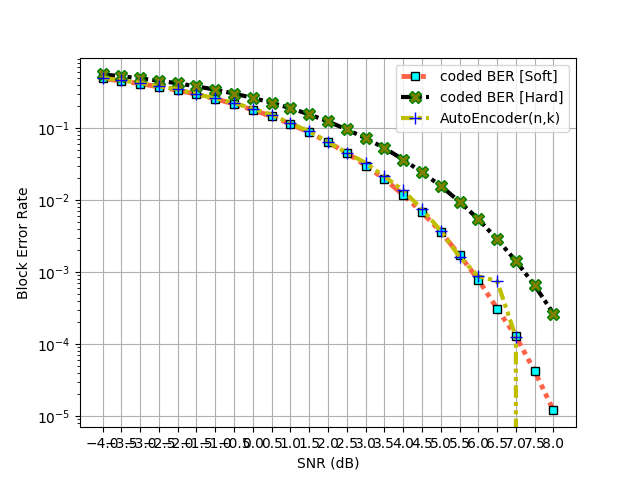

In [19]:
# ploting BLER 
fig, ax = plt.subplots()

ax.semilogy(snr_dB, codedBLERsoft, 'tomato', lw = 3.5, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "s", ms = 6, mec = "k", mfc = "cyan", label = "coded BER [Soft]")
ax.semilogy(snr_dB, codedBLERhard, 'k', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "X", ms = 9, mec = "green", mfc = "olive", label = "coded BER [Hard]")
ax.semilogy(snr_dB, bler, 'y', lw = 3, linestyle = (0, (3, 1, 1, 1, 1, 1)), marker = "+", ms = 9, mec = "blue", mfc = "pink", label = "AutoEncoder(n,k)")
ax.legend()
ax.set_xticks(snr_dB)
ax.grid()
ax.set_ylabel("Block Error Rate")
ax.set_xlabel("SNR (dB)")

plt.show()

## Constellation Learning

The following cells provide the code to generate and plot the learned constellation by Tx in the presence of AWGN.


**Note:** we have to go back to the previous steps to change the values of `N`,`N_test` and `retrain the AE` to plot a constellation for `(7,4) AE` as it uses `TSNE`. For other cases such as (2,4) and (2,2) we can use same `N`,`N_test` for BLER and constellation plots.

In [20]:
# #################################################################################
# # predicting the learned constellation for a given number of information symbols M
# #################################################################################
# constellationPoints = transmitter.predict(symbol_encodings)
# print("\n")
# print(constellationPoints)
# print("\n")
# print("Shape of learned constellation:" + str(constellationPoints.shape))

### learned constellation plot

1/1 [==============================] - 0s 26ms/step


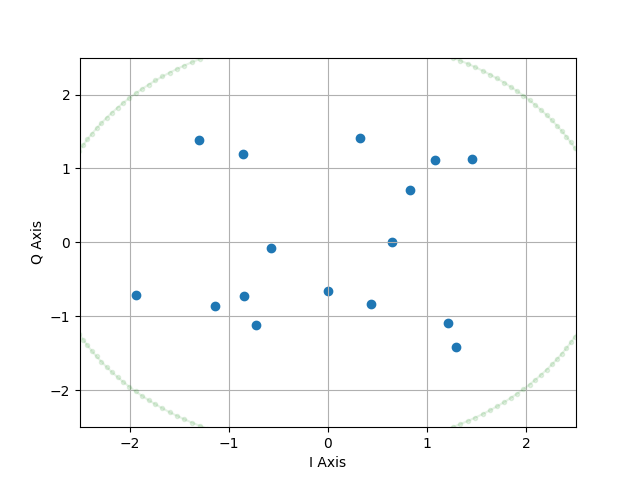

In [21]:
###################################################################################
# plotting learned constellation under energy constraint for (n,k) = (2,4) or (2,2)
###################################################################################
constellationPoints = transmitter.predict(symbol_encodings)
r = np.linalg.norm(constellationPoints[0])
theta = np.linspace(0,2*np.pi,200)
fig, ax = plt.subplots()
ax.scatter(constellationPoints[:,0],constellationPoints[:,1])
ax.plot(r*np.cos(theta),r*np.sin(theta), c="green", alpha = 0.1, marker=".")
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

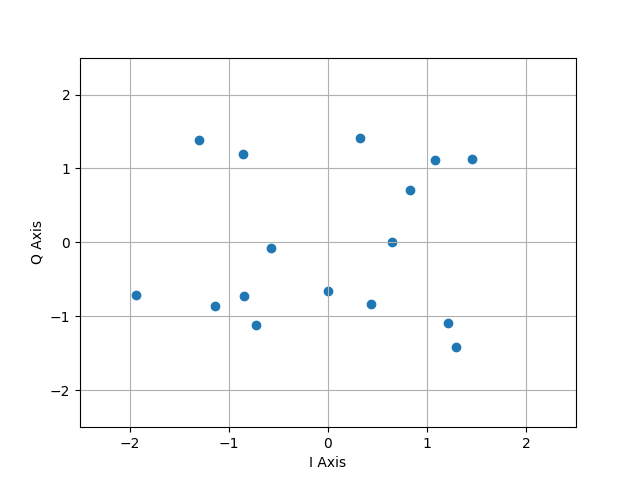

In [22]:
##########################################################################################
# plotting learned constellation under average power constraint for (n,k) = (2,4) or (2,2)
##########################################################################################

fig, ax = plt.subplots()
ax.scatter(constellationPoints[:,0],constellationPoints[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.xlabel('I Axis')
plt.ylabel('Q Axis')
plt.show()

The following code snippet use TSNE to reduce the dimension of constellation for `(n,k) = (7,4)` 

In [23]:
# ###########################################################################################################
# # Using sklearn T-distributed Stochastic Neighbor Embedding (TSNE) to reduce the dimension of constellation
# ###########################################################################################################
# num_samples = N_test 

# noise       = noise_stddev*np.random.randn(num_samples,n)
# X           = transmitter.predict(test_data)
# X_noisy     = X + noise

# X_embedded  = TSNE(n_components=2, learning_rate='auto', n_iter = 35000, random_state = 0, perplexity=60).fit_transform(X_noisy)
# X_embedded  = X_embedded/n

In [24]:
# ####################################################################################
# # plotting higher dimensional received constellation in lower dimensions for (7,4) AE
# ####################################################################################
# fig, ax = plt.subplots()
# ax.scatter(X_embedded[:,0],X_embedded[:,1], marker = ".")
# plt.axis((-2,2,-2,2))
# plt.grid()
# plt.xlabel('I Axis')
# plt.ylabel('Q Axis')
# plt.show()

#### For (n,k) = (2,4) or (2,2) AutoEncoders


It turns out that under M = 16 and with an `energy constraint`, `(2,4) AE` learns a constellation which resemble `16-ary PSK` and with `power constraint` it learns a constellation which resemble `16-ary APSK`.

## References


[1] T. O’Shea and J. Hoydis, "An Introduction to Deep Learning for the Physical Layer," in IEEE Transactions on 
Cognitive Communications and Networking, vol. 3, no. 4, pp. 563-575, Dec. 2017, doi: 10.1109/TCCN.2017.2758370.